In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.profiler import profiler_v2
from keras.callbacks import EarlyStopping

from tensorflow.keras.models import load_model
from sklearn.model_selection import StratifiedKFold
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
from tensorflow.keras.models import save_model


from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
import time


2023-06-23 13:39:38.150860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 데이터 불러오기 및 클래스 분포 시각화

In [4]:
images_origin = np.load('images_origin.npy')
labels_origin = np.load('labels_origin.npy')

images_origin.shape, labels_origin.shape

((3000, 224, 224, 3), (3000,))

[1091 1909]


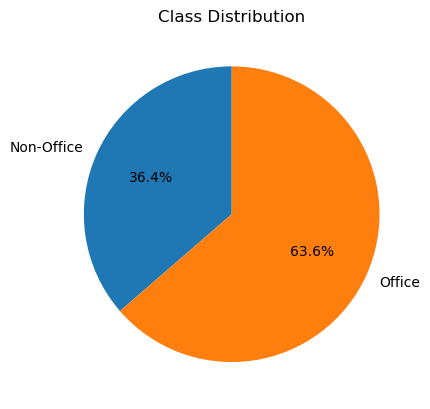

In [3]:
# 클래스 분포 확인
# numpy의 bincount 함수 활용
# bincount의 결과값 -> [1651, 1349] 순서대로 0의 빈도수, 1이 빈도수를 나타냄

class_counts = np.bincount(labels_origin.flatten())
print(class_counts)

# 클래스 레이블 생성
class_labels = ['Non-Office', 'Office']

# 파이 차트로 클래스 별 상대적인 비율을 시각화
plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution')
plt.show()

### 훈련/테스트 데이터로 분리

In [5]:
x_train, x_test, y_train, y_test = train_test_split(images_origin, labels_origin, 
                                                    test_size=0.2,stratify=labels_origin, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2400, 224, 224, 3), (600, 224, 224, 3), (2400,), (600,))

### 간단한 구조의 CNN 모델 생성
#### 합성곱층의 적절한 필터 개수 선정 (8 -> 16 -> 32)

In [13]:
# 합성곱층의 필터 개수를 8개로 선정하고 교차 검증을 실행
# epoch 5로 설정 후 교차 검증 시 도출되는 정확도를 빈 리스트에 저장

# 교차 검증을 위한 StratifiedKFold 객체 생성 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 빈 리스트 생성
scores_8 = []

# 반복문을 통한 교차 검증 실행
for train_index, val_index in kfold.split(x_train, y_train):
    X_train, X_val = x_train[train_index], x_train[val_index]
    Y_train, Y_val = y_train[train_index], y_train[val_index]
    
    CNN_filter8 = tf.keras.Sequential([
                        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
                        tf.keras.layers.MaxPooling2D((2, 2)),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(64, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(1, activation='sigmoid')
                        ])

    CNN_filter8.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    CNN_filter8.fit(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val))
    
    
    # 언더 스코어를 통해 손실 값을 제외하고, 평가 지표만 변수에 저장
    _, score = CNN_filter8.evaluate(X_val, Y_val)
    scores_8.append(score)

print("Cross-Validation Accuracy:", np.mean(scores_8))

Epoch 1/5
68/68 [==============================] - 18s 254ms/step - loss: 1.2544 - accuracy: 0.7227 - val_loss: 0.2318 - val_accuracy: 0.9083
Epoch 2/5
68/68 [==============================] - 16s 232ms/step - loss: 0.2569 - accuracy: 0.8968 - val_loss: 0.0876 - val_accuracy: 0.9667
Epoch 3/5
68/68 [==============================] - 15s 228ms/step - loss: 0.1498 - accuracy: 0.9468 - val_loss: 0.0970 - val_accuracy: 0.9542
Epoch 4/5
68/68 [==============================] - 16s 228ms/step - loss: 0.1091 - accuracy: 0.9639 - val_loss: 0.0463 - val_accuracy: 0.9917
Epoch 5/5
8/8 [==============================] - 1s 77ms/step - loss: 0.0490 - accuracy: 0.9875
Epoch 1/5
68/68 [==============================] - 17s 236ms/step - loss: 2.9311 - accuracy: 0.5755 - val_loss: 0.5456 - val_accuracy: 0.6375
Epoch 2/5
68/68 [==============================] - 16s 231ms/step - loss: 0.6105 - accuracy: 0.6190 - val_loss: 0.5214 - val_accuracy: 0.6375
Epoch 3/5
68/68 [==============================] - 1

In [14]:
# 합성곱층의 필터 개수를 16개로 선정하고 교차 검증을 실행
# epoch 5로 설정 후 교차 검증 시 도출되는 정확도를 빈 리스트에 저장

# 교차 검증을 위한 StratifiedKFold 객체 생성 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 빈 리스트 생성
scores_16 = []

# 반복문을 통한 교차 검증 실행
for train_index, val_index in kfold.split(x_train, y_train):
    X_train, X_val = x_train[train_index], x_train[val_index]
    Y_train, Y_val = y_train[train_index], y_train[val_index]
    
    CNN_filter16 = tf.keras.Sequential([
                        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
                        tf.keras.layers.MaxPooling2D((2, 2)),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(64, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(1, activation='sigmoid')
                        ])

    CNN_filter16.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    CNN_filter16.fit(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val))
    
    
    # 언더 스코어를 통해 손실 값을 제외하고, 평가 지표만 변수에 저장
    _, score = CNN_filter16.evaluate(X_val, Y_val)
    scores_16.append(score)

print("Cross-Validation Accuracy:", np.mean(scores_16))

Epoch 1/5
68/68 [==============================] - 21s 305ms/step - loss: 3.5705 - accuracy: 0.5995 - val_loss: 0.5295 - val_accuracy: 0.7083
Epoch 2/5
68/68 [==============================] - 20s 293ms/step - loss: 0.5475 - accuracy: 0.6741 - val_loss: 0.4013 - val_accuracy: 0.8458
Epoch 3/5
68/68 [==============================] - 20s 297ms/step - loss: 0.4151 - accuracy: 0.7620 - val_loss: 0.2582 - val_accuracy: 0.9167
Epoch 4/5
68/68 [==============================] - 20s 295ms/step - loss: 0.3271 - accuracy: 0.7991 - val_loss: 0.1645 - val_accuracy: 0.9792
Epoch 5/5
8/8 [==============================] - 1s 90ms/step - loss: 0.1964 - accuracy: 0.9833
Epoch 1/5
68/68 [==============================] - 21s 308ms/step - loss: 2.6607 - accuracy: 0.5912 - val_loss: 0.5557 - val_accuracy: 0.6375
Epoch 2/5
68/68 [==============================] - 20s 296ms/step - loss: 0.5313 - accuracy: 0.6880 - val_loss: 0.3994 - val_accuracy: 0.7542
Epoch 3/5
68/68 [==============================] - 2

In [15]:
# 합성곱층의 필터 개수를 32개로 선정하고 교차 검증을 실행
# epoch 5로 설정 후 교차 검증 시 도출되는 정확도를 빈 리스트에 저장

# 교차 검증을 위한 StratifiedKFold 객체 생성 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 빈 리스트 생성
scores_32 = []

# 반복문을 통한 교차 검증 실행
for train_index, val_index in kfold.split(x_train, y_train):
    X_train, X_val = x_train[train_index], x_train[val_index]
    Y_train, Y_val = y_train[train_index], y_train[val_index]
    
    CNN_filter32 = tf.keras.Sequential([
                        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
                        tf.keras.layers.MaxPooling2D((2, 2)),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(64, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(1, activation='sigmoid')
                        ])

    CNN_filter32.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    CNN_filter32.fit(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val))
    
    
    # 언더 스코어를 통해 손실 값을 제외하고, 평가 지표만 변수에 저장
    _, score = CNN_filter32.evaluate(X_val, Y_val)
    scores_32.append(score)

print("Cross-Validation Accuracy:", np.mean(scores_32))

Epoch 1/5
68/68 [==============================] - 49s 710ms/step - loss: 3.4904 - accuracy: 0.6106 - val_loss: 0.5012 - val_accuracy: 0.6500
Epoch 2/5
68/68 [==============================] - 42s 618ms/step - loss: 0.4691 - accuracy: 0.7556 - val_loss: 0.2989 - val_accuracy: 0.8875
Epoch 3/5
68/68 [==============================] - 43s 628ms/step - loss: 0.3145 - accuracy: 0.8819 - val_loss: 0.1584 - val_accuracy: 0.9458
Epoch 4/5
68/68 [==============================] - 44s 640ms/step - loss: 0.1954 - accuracy: 0.9296 - val_loss: 0.2062 - val_accuracy: 0.9792
Epoch 5/5
8/8 [==============================] - 2s 199ms/step - loss: 0.0547 - accuracy: 0.9750
Epoch 1/5
68/68 [==============================] - 45s 651ms/step - loss: 2.3189 - accuracy: 0.5944 - val_loss: 0.5388 - val_accuracy: 0.6417
Epoch 2/5
68/68 [==============================] - 44s 639ms/step - loss: 0.3883 - accuracy: 0.8227 - val_loss: 0.2461 - val_accuracy: 0.8875
Epoch 3/5
68/68 [==============================] - 

In [16]:
# 필터 개수 변화에 따른 CV Score 확인

DS1_cvscore = pd.DataFrame({'Filter_8' : scores_8,
                           'Filter_16' : scores_16,
                           'Filter_32' : scores_32})
DS1_cvscore = round(DS1_cvscore * 100, 2)
DS1_cvscore.to_csv('DS1_cvscore.csv',index=False)

In [18]:
print(DS1_cvscore['Filter_8'].mean(), DS1_cvscore['Filter_16'].mean(), DS1_cvscore['Filter_32'].mean())
DS1_cvscore

98.084 97.458 96.708


,Filter_8,Filter_16,Filter_32
0,98.75,98.33,97.50
1,97.92,98.33,98.33
2,96.67,99.17,92.92
3,98.33,92.92,97.50
4,99.17,99.17,98.75
5,97.50,98.33,97.92
6,98.33,97.92,95.83
7,97.92,93.33,98.33
8,98.75,98.33,96.25
9,97.50,98.75,93.75


In [25]:
print(DS1_cvscore['Filter_8'].mean(), DS1_cvscore['Filter_8'].std())
print(DS1_cvscore['Filter_16'].mean(), DS1_cvscore['Filter_16'].std())
print(DS1_cvscore['Filter_32'].mean(), DS1_cvscore['Filter_32'].std(),'\n')

print(stats.ttest_ind(DS1_cvscore['Filter_8'],DS1_cvscore['Filter_16']))
print(stats.ttest_ind(DS1_cvscore['Filter_16'],DS1_cvscore['Filter_32']))
print(stats.ttest_ind(DS1_cvscore['Filter_8'],DS1_cvscore['Filter_32']))

98.084 0.7395824647882221
97.458 2.3194817428804124
96.708 2.0064994393221243 

Ttest_indResult(statistic=0.8131256924504227, pvalue=0.4267710790600089)
Ttest_indResult(statistic=0.7733177084696172, pvalue=0.44937150721552066)
Ttest_indResult(statistic=2.034776803390471, pvalue=0.05687463382725055)


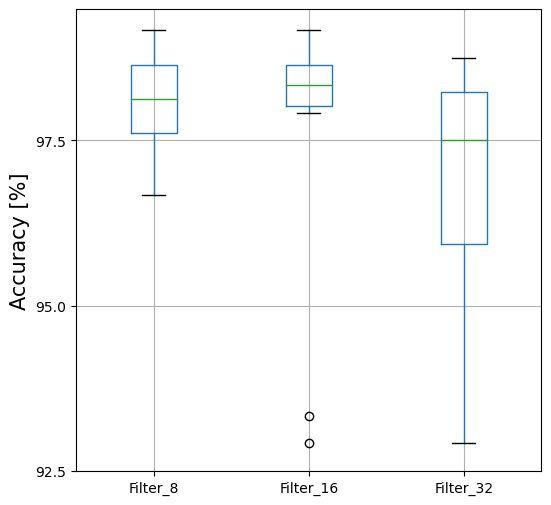

In [24]:
plt.figure(figsize=(6,6))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
DS1_cvscore.boxplot()
plt.yticks(np.arange(92.5,100,2.5))
plt.ylabel('Accuracy [%]',fontsize=15)

plt.savefig('Filter_Accuracy.png')
plt.show()

### 필터 개수에 따라 정확도에 유의미한 차이가 없는 것으로 판단되어 필터 개수는 8개로 선정 -> 연산량을 줄임 (P-Value > 0.05)
##### 연산량 감소를 위해 1x1 convolution layer 적용

In [28]:
# 합성곱층의 필터 개수를 8개로 선정하고 교차 검증을 실행
# 1x1 convolution Layer -> filters : 2

# epoch 5로 설정 후 교차 검증 시 도출되는 정확도를 빈 리스트에 저장

# 교차 검증을 위한 StratifiedKFold 객체 생성 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 빈 리스트 생성
scores_with_1by1 = []

# 반복문을 통한 교차 검증 실행
for train_index, val_index in kfold.split(x_train, y_train):
    X_train, X_val = x_train[train_index], x_train[val_index]
    Y_train, Y_val = y_train[train_index], y_train[val_index]
    
    CNN_with_1by1 = tf.keras.Sequential([
                        tf.keras.layers.Conv2D(2, (1, 1), activation='relu', input_shape=(224, 224, 3)),
                        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
                        tf.keras.layers.MaxPooling2D((2, 2)),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(64, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(1, activation='sigmoid')
                        ])

    CNN_with_1by1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    CNN_with_1by1.fit(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val))
    
    
    # 언더 스코어를 통해 손실 값을 제외하고, 평가 지표만 변수에 저장
    _, score = CNN_with_1by1.evaluate(X_val, Y_val)
    scores_with_1by1.append(score)
    
print("Cross-Validation Accuracy:", np.mean(scores_with_1by1))

Epoch 1/5
68/68 [==============================] - 25s 355ms/step - loss: 2.3172 - accuracy: 0.5819 - val_loss: 0.5118 - val_accuracy: 0.6417
Epoch 2/5
68/68 [==============================] - 22s 318ms/step - loss: 0.6215 - accuracy: 0.6819 - val_loss: 0.4298 - val_accuracy: 0.8083
Epoch 3/5
68/68 [==============================] - 22s 320ms/step - loss: 0.5540 - accuracy: 0.7046 - val_loss: 0.6682 - val_accuracy: 0.6542
Epoch 4/5
68/68 [==============================] - 22s 318ms/step - loss: 0.5563 - accuracy: 0.7079 - val_loss: 0.2011 - val_accuracy: 0.9375
Epoch 5/5
8/8 [==============================] - 1s 80ms/step - loss: 0.1067 - accuracy: 0.9667
Epoch 1/5
68/68 [==============================] - 24s 346ms/step - loss: 0.6629 - accuracy: 0.6282 - val_loss: 0.6489 - val_accuracy: 0.6458
Epoch 2/5
68/68 [==============================] - 22s 322ms/step - loss: 0.6292 - accuracy: 0.6616 - val_loss: 0.6285 - val_accuracy: 0.6875
Epoch 3/5
68/68 [==============================] - 2

In [39]:
# 합성곱층의 필터 개수를 8개로 선정하고 교차 검증을 실행
# 1x1 convolution Layer -> filters : 1

# epoch 5로 설정 후 교차 검증 시 도출되는 정확도를 빈 리스트에 저장

# 교차 검증을 위한 StratifiedKFold 객체 생성 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 빈 리스트 생성
scores_with_1by1_1 = []

# 반복문을 통한 교차 검증 실행
for train_index, val_index in kfold.split(x_train, y_train):
    X_train, X_val = x_train[train_index], x_train[val_index]
    Y_train, Y_val = y_train[train_index], y_train[val_index]
    
    CNN_with_1by1_1 = tf.keras.Sequential([
                        tf.keras.layers.Conv2D(1, (1, 1), activation='relu', input_shape=(224, 224, 3)),
                        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
                        tf.keras.layers.MaxPooling2D((2, 2)),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(64, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(1, activation='sigmoid')
                        ])

    CNN_with_1by1_1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    CNN_with_1by1_1.fit(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val))
    
    
    # 언더 스코어를 통해 손실 값을 제외하고, 평가 지표만 변수에 저장
    _, score = CNN_with_1by1_1.evaluate(X_val, Y_val)
    scores_with_1by1_1.append(score)
    
print("Cross-Validation Accuracy:", np.mean(scores_with_1by1_1))

Epoch 1/5
68/68 [==============================] - 26s 360ms/step - loss: 0.6896 - accuracy: 0.6296 - val_loss: 0.6860 - val_accuracy: 0.6375
Epoch 2/5
68/68 [==============================] - 22s 327ms/step - loss: 0.6829 - accuracy: 0.6361 - val_loss: 0.6799 - val_accuracy: 0.6375
Epoch 3/5
68/68 [==============================] - 25s 374ms/step - loss: 0.6775 - accuracy: 0.6361 - val_loss: 0.6747 - val_accuracy: 0.6375
Epoch 4/5
68/68 [==============================] - 26s 381ms/step - loss: 0.6729 - accuracy: 0.6361 - val_loss: 0.6707 - val_accuracy: 0.6375
Epoch 5/5
8/8 [==============================] - 1s 92ms/step - loss: 0.6672 - accuracy: 0.6375
Epoch 1/5
68/68 [==============================] - 25s 353ms/step - loss: 0.6584 - accuracy: 0.6333 - val_loss: 0.6481 - val_accuracy: 0.6625
Epoch 2/5
68/68 [==============================] - 27s 397ms/step - loss: 0.6273 - accuracy: 0.6782 - val_loss: 0.6074 - val_accuracy: 0.7083
Epoch 3/5
68/68 [==============================] - 2

In [46]:
# 1x1 convolution Layer를 추가한 모델의 교차 검증 데이터를 DS1_cvscore 데이터 프레임에 추가

# 1x1 convolution Layer, Filter = 2 
DS1_cvscore['1x1_CL_Filter2'] = scores_with_1by1
DS1_cvscore['1x1_CL_Filter2'] = round(DS1_cvscore['1x1_CL_Filter2'] * 100, 2)

# 1x1 convolution Layer, Filter = 1 
DS1_cvscore['1x1_CL_Filter1'] = scores_with_1by1_1
DS1_cvscore['1x1_CL_Filter1'] = round(DS1_cvscore['1x1_CL_Filter1'] * 100, 2)

DS1_cvscore.to_csv('DS1_cvscore.csv',index=False)

# 1x1 convolution Layer를 추가하기 이전 / 이후의 점수(정확도) 간에 통계적으로 유의미한 차이가 존재하는지 확인
# P-Value > 0.05로 통계적으로 유의미한 차이가 존재하지 않는 것으로 판단됨. 

print(stats.ttest_ind(DS1_cvscore['Filter_8'],DS1_cvscore['1x1_CL_Filter2']))
print(stats.ttest_ind(DS1_cvscore['Filter_8'],DS1_cvscore['1x1_CL_Filter1']))
print(stats.ttest_ind(DS1_cvscore['1x1_CL_Filter1'],DS1_cvscore['1x1_CL_Filter2']))

DS1_cvscore

Ttest_indResult(statistic=1.3693407100639399, pvalue=0.1877369141722065)
Ttest_indResult(statistic=2.0592189756460093, pvalue=0.05424051290045531)
Ttest_indResult(statistic=-0.8240093571749549, pvalue=0.4207191752863806)


,Filter_8,Filter_16,Filter_32,1x1_CL_Filter2,1x1_CL_Filter1
0,98.75,98.33,97.50,96.67,63.75
1,97.92,98.33,98.33,98.33,97.50
2,96.67,99.17,92.92,98.33,63.75
3,98.33,92.92,97.50,98.33,98.75
4,99.17,99.17,98.75,76.67,63.75
5,97.50,98.33,97.92,63.75,99.58
6,98.33,97.92,95.83,98.75,97.50
7,97.92,93.33,98.33,97.50,96.25
8,98.75,98.33,96.25,99.17,95.83
9,97.50,98.75,93.75,100.00,97.50


In [88]:
# 1x1 convolution 적용에 따른 교차 검증 점수의 평균, 표준 편차 확인

print(DS1_cvscore['Filter_8'].mean(), DS1_cvscore['Filter_8'].std())
print(DS1_cvscore['1x1_CL_Filter2'].mean(), DS1_cvscore['1x1_CL_Filter2'].std())

98.084 0.7395824647882221
92.74999999999999 12.295814102549064


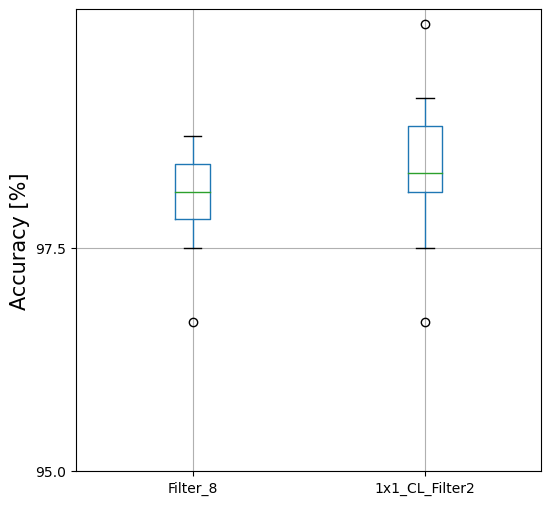

In [95]:
Second_boxplot = DS1_cvscore.drop(columns = ['Filter_16','Filter_32','1x1_CL_Filter1'])

# 시각화를 위해 이상치로 판별되는 데이터 중 정확도 80이하의 데이터를 drop

drop_index = Second_boxplot.loc[Second_boxplot['1x1_CL_Filter2'] < 80].index
Second_boxplot.drop(drop_index, inplace=True)

plt.figure(figsize=(6,6))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
Second_boxplot.boxplot()
plt.yticks(np.arange(95,100,2.5))
plt.ylabel('Accuracy [%]',fontsize=15)

plt.savefig('1x1 Convolution Layer.png')
plt.show()

#### Filter = 8, 1x1 Convolution Layer 적용 이전/이후의 모델 생성

In [28]:
# Train / Validation / Test data 분리
# 이미 Train / Test로 데이터가 분리되어 있어 Train 데이터를 Train / Val 데이터로 세부 구분 

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                    test_size=0.2,stratify=y_train, random_state=42)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1920, 224, 224, 3), (480, 224, 224, 3), (1920,), (480,))

In [35]:
# Convolution layer -> filter : 8
# 1x1 convolution layer x

CNN_Model = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
                    tf.keras.layers.MaxPooling2D((2, 2)),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(1, activation='sigmoid')
                    ])

CNN_Model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
CNN_Model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
60/60 [==============================] - 24s 377ms/step - loss: 1.0285 - accuracy: 0.6281 - val_loss: 0.5149 - val_accuracy: 0.6979
Epoch 2/5
60/60 [==============================] - 21s 344ms/step - loss: 0.4503 - accuracy: 0.7661 - val_loss: 0.3013 - val_accuracy: 0.8958
Epoch 3/5
60/60 [==============================] - 20s 330ms/step - loss: 0.2519 - accuracy: 0.9047 - val_loss: 0.1409 - val_accuracy: 0.9396
Epoch 4/5
60/60 [==============================] - 18s 301ms/step - loss: 0.1414 - accuracy: 0.9604 - val_loss: 0.0816 - val_accuracy: 0.9708
Epoch 5/5
60/60 [==============================] - 18s 300ms/step - loss: 0.0779 - accuracy: 0.9760 - val_loss: 0.0456 - val_accuracy: 0.9896


In [34]:
# Convolution layer -> filter : 8
# 1x1 convolution layer -> filter : 2


CNN_Model_1by1 = tf.keras.Sequential([
                        tf.keras.layers.Conv2D(2, (1, 1), activation='relu', input_shape=(224, 224, 3)),
                        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
                        tf.keras.layers.MaxPooling2D((2, 2)),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(64, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(1, activation='sigmoid')
                        ])

CNN_Model_1by1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
CNN_Model_1by1.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
60/60 [==============================] - 21s 343ms/step - loss: 0.7675 - accuracy: 0.7182 - val_loss: 0.2905 - val_accuracy: 0.9125
Epoch 2/5
60/60 [==============================] - 21s 349ms/step - loss: 0.2427 - accuracy: 0.9078 - val_loss: 0.0749 - val_accuracy: 0.9771
Epoch 3/5
60/60 [==============================] - 21s 346ms/step - loss: 0.1262 - accuracy: 0.9578 - val_loss: 0.0457 - val_accuracy: 0.9833
Epoch 4/5
60/60 [==============================] - 21s 352ms/step - loss: 0.0861 - accuracy: 0.9771 - val_loss: 0.0343 - val_accuracy: 0.9854
Epoch 5/5
60/60 [==============================] - 21s 346ms/step - loss: 0.0917 - accuracy: 0.9719 - val_loss: 0.0628 - val_accuracy: 0.9833


In [50]:
# 모델 h5 파일 형태로 저장 

CNN_Model.save("CNN_Model.h5")
CNN_Model_1by1.save("CNN_Model_1by1_filter2.h5")
CNN_Model_1by1_1.save("CNN_Model_1by1_filter1.h5")

### 로컬 환경에서의 추론 속도 Test

In [32]:
# 추론 속도를 측정하는 함수 정의

def inference_time_test(model, num):
    inference_time = []
    # x_test 데이터 중 하나의 데이터만 활용 
    sample_data = x_test[0]
    
    # (224,224,3) -> (1,224,224,3)의 형태로 변환하기 위한 차원 확장
    sample_data = np.expand_dims(sample_data, axis=0)
    
    for i in list(range(num)):
            
        start_time = time.time()
        prediction = model.predict(sample_data)
        end_time = time.time()
        
        time_diff = end_time - start_time
        inference_time.append(time_diff)
        
    return inference_time  

In [69]:
inference_time_CNN = inference_time_test(CNN_Model,50)
inference_time_filter2_1x1 = inference_time_test(CNN_Model_1by1,50)

1/1 [==============================] - 0s 27ms/step


In [98]:
print(stats.ttest_ind(inference_time_CNN,inference_time_filter2_1x1 ))

Ttest_indResult(statistic=8.137524562144852, pvalue=1.289794112235736e-12)


In [100]:
timetest_local = pd.DataFrame({'CNN_Model' : inference_time_CNN, 
                               'CNN_Model_1by1_filter2' : inference_time_filter2_1x1
                              })

timetest_local = round(timetest_local, 5)
timetest_local.to_csv('timetest_local.csv',index=False)

print(timetest_local['CNN_Model'].mean(),timetest_local['CNN_Model_1by1_filter2'].mean())
print(timetest_local['CNN_Model'].std(),timetest_local['CNN_Model_1by1_filter2'].std())
print(timetest_local['CNN_Model'].max(),timetest_local['CNN_Model_1by1_filter2'].max())
print(timetest_local['CNN_Model'].min(),timetest_local['CNN_Model_1by1_filter2'].min())

timetest_local

0.06998919999999999 0.0593572
0.006817108382142501 0.0062335399711102015
0.09174 0.07703
0.05788 0.05037


,CNN_Model,CNN_Model_1by1_filter2
0,0.06419,0.05769
1,0.06227,0.06179
2,0.05788,0.05684
3,0.09174,0.07703
4,0.06929,0.07465
5,0.06490,0.06388
6,0.08749,0.06284
7,0.07094,0.05447
8,0.06412,0.05814
9,0.06678,0.05491


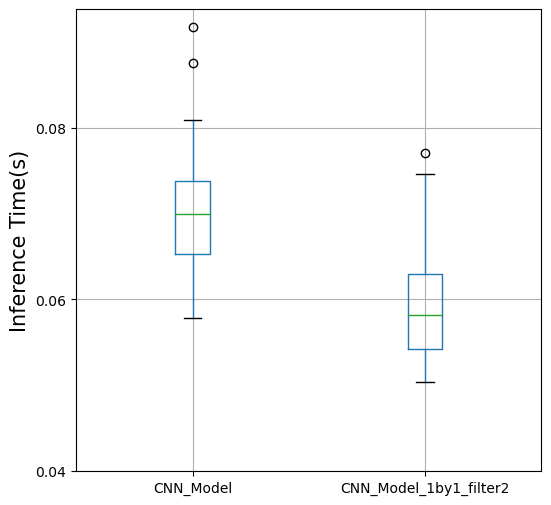

In [106]:
# 추론 시간에 대한 boxplot - 1x1 convolution 적용 이전과 이후

plt.figure(figsize=(6,6))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
timetest_local.boxplot()
plt.yticks(np.arange(0.04,0.1,0.02))
plt.ylabel('Inference Time(s)',fontsize=15)

plt.savefig('Inference Time(s).png')
plt.show()

### 모델 비교
#### CNN (1x1 convolution layer : filter 2) - MobileNetV2 간 비교

In [6]:
# MobileNetV2 불러오기
model_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 기존 모델의 상위 레이어 동결
model_base.trainable = False 

# 교차 검증을 위한 StratifiedKFold 객체 생성 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# 빈 리스트 생성
MobileNetV2 = []

# 반복문을 통한 교차 검증 실행
for train_index, val_index in kfold.split(x_train, y_train):
    X_train, X_val = x_train[train_index], x_train[val_index]
    Y_train, Y_val = y_train[train_index], y_train[val_index]

    
    MobileNet = tf.keras.Sequential([
                        model_base,
                        tf.keras.layers.GlobalAveragePooling2D(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(64, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(1, activation='sigmoid')
                        ])
    
    MobileNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    MobileNet.fit(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val))
    
    # 언더 스코어를 통해 손실 값을 제외하고, 평가 지표만 변수에 저장
    _, score = MobileNet.evaluate(X_val, Y_val)
    MobileNetV2.append(score)
    
print("Cross-Validation Accuracy:", np.mean(MobileNetV2))

2023-06-23 13:40:12.609290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
68/68 [==============================] - 52s 714ms/step - loss: 0.4302 - accuracy: 0.8009 - val_loss: 0.1135 - val_accuracy: 0.9625
Epoch 2/5
68/68 [==============================] - 47s 686ms/step - loss: 0.1275 - accuracy: 0.9458 - val_loss: 0.0754 - val_accuracy: 0.9667
Epoch 3/5
68/68 [==============================] - 45s 668ms/step - loss: 0.0647 - accuracy: 0.9787 - val_loss: 0.0856 - val_accuracy: 0.9708
Epoch 4/5
68/68 [==============================] - 46s 679ms/step - loss: 0.0391 - accuracy: 0.9875 - val_loss: 0.0539 - val_accuracy: 0.9792
Epoch 5/5
8/8 [==============================] - 5s 566ms/step - loss: 0.0591 - accuracy: 0.9750
Epoch 1/5
68/68 [==============================] - 49s 681ms/step - loss: 0.4267 - accuracy: 0.8005 - val_loss: 0.0886 - val_accuracy: 0.9958
Epoch 2/5
68/68 [==============================] - 44s 649ms/step - loss: 0.1359 - accuracy: 0.9519 - val_loss: 0.0313 - val_accuracy: 0.9875
Epoch 3/5
68/68 [==============================] - 

In [19]:
# 정확도 비교

CNN = [96.67, 98.33, 98.33, 98.33, 76.67, 63.75, 98.75, 97.50, 99.17, 100.00]

Model_Comparison = pd.DataFrame({'CNN' : CNN,
                               'MobileNetV2' : MobileNetV2
                                })

Model_Comparison['MobileNetV2'] = round(Model_Comparison['MobileNetV2'] * 100, 2)
Model_Comparison.to_csv('Model_Comparison.csv',index=False)

In [20]:
print(Model_Comparison['CNN'].mean(), Model_Comparison['CNN'].std())
print(Model_Comparison['MobileNetV2'].mean(), Model_Comparison['MobileNetV2'].std())


print(stats.ttest_ind(Model_Comparison['CNN'], Model_Comparison['MobileNetV2']))

92.74999999999999 12.295814102549064
98.667 0.7817793095809646
Ttest_indResult(statistic=-1.518686823799587, pvalue=0.14621042229978445)


In [21]:
Model_Comparison

,CNN,MobileNetV2
0,96.67,97.50
1,98.33,99.17
2,98.33,98.75
3,98.33,98.75
4,76.67,98.33
5,63.75,100.00
6,98.75,97.50
7,97.50,99.17
8,99.17,99.17
9,100.00,98.33


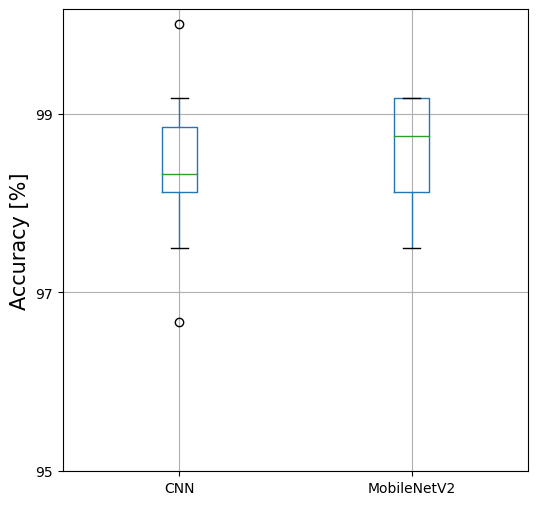

In [30]:
# 시각화를 위해 이상치로 판별되는 데이터 중 정확도 80이하의 데이터를 drop

drop_index = Model_Comparison.loc[Model_Comparison['CNN'] < 80].index
Model_Comparison_drop = Model_Comparison.drop(drop_index)



plt.figure(figsize=(6,6))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
Model_Comparison_drop.boxplot()
plt.yticks(np.arange(95,100,2))
plt.ylabel('Accuracy [%]',fontsize=15)

plt.savefig('Model_Comparison.png')
plt.show()

In [29]:
# 추론 속도 측정을 위한 모델 정의

MobileNet = tf.keras.Sequential([
                        model_base,
                        tf.keras.layers.GlobalAveragePooling2D(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(64, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(1, activation='sigmoid')
                        ])
    
MobileNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
MobileNet.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
60/60 [==============================] - 48s 766ms/step - loss: 0.4324 - accuracy: 0.7917 - val_loss: 0.1011 - val_accuracy: 0.9792
Epoch 2/5
60/60 [==============================] - 46s 768ms/step - loss: 0.1450 - accuracy: 0.9432 - val_loss: 0.0504 - val_accuracy: 0.9896
Epoch 3/5
60/60 [==============================] - 45s 750ms/step - loss: 0.0802 - accuracy: 0.9724 - val_loss: 0.0397 - val_accuracy: 0.9854
Epoch 4/5
60/60 [==============================] - 48s 795ms/step - loss: 0.0615 - accuracy: 0.9859 - val_loss: 0.0779 - val_accuracy: 0.9729
Epoch 5/5
60/60 [==============================] - 46s 769ms/step - loss: 0.0336 - accuracy: 0.9896 - val_loss: 0.0191 - val_accuracy: 0.9917


In [41]:
MobileNet.save("MobileNet.h5")

In [38]:
# 로컬 환경에서의 추론 속도 측정 

inferencetime_MobileNet = inference_time_test(MobileNet,50)
inferencetime_CNN = inference_time_test(CNN_Model_1by1,50)


print(stats.ttest_ind(inferencetime_CNN,inferencetime_MobileNet ))

1/1 [==============================] - 0s 29ms/step
Ttest_indResult(statistic=-11.276809155072097, pvalue=2.105709208145139e-19)


In [61]:
# 테스트 페이지 상에서의 추론 속도 측정 

inferencetime_CNN_Test = [0.08034, 0.08039, 0.09086, 0.0887, 0.0839, 0.08923, 0.07699, 0.07227, 0.08746, 0.08628, 0.09631, 0.08736, 0.09495, 0.08898, 0.09667, 0.08342, 0.08326, 0.0981, 0.08996, 0.09287, 0.08935, 0.09975, 0.09144, 0.09715, 0.09102, 0.09964, 0.09698, 0.10648, 0.09045, 0.10699, 0.08523, 0.08726, 0.08319, 0.08482, 0.09022, 0.09872, 0.08357, 0.0879, 0.08974, 0.09645, 0.12249, 0.09774, 0.0872, 0.10465, 0.10335, 0.09827, 0.09099, 0.09897, 0.08883, 0.10358]
inferencetime_MobileNet_Test = [0.66804, 0.69366, 0.74993, 0.58181, 0.66195, 0.57457, 0.5477, 0.5763, 0.58927, 0.58261, 0.54214, 0.58225, 0.60446, 0.56627, 0.55334, 0.58505, 0.58357, 0.57781, 0.58091, 0.84131, 0.55842, 0.55983, 0.56629, 0.81025, 0.53864, 0.57259, 0.58169, 0.92479, 0.61197, 0.59047, 0.59939, 0.90193, 0.65696, 0.56018, 0.54332, 0.7809, 0.53569, 0.54049, 0.53974, 0.76467, 0.54044, 0.52946, 0.52112, 0.76606, 0.54387, 0.54322, 0.53784, 0.76097, 0.53715, 0.54116]

print(stats.ttest_ind(inferencetime_CNN_Test, inferencetime_MobileNet_Test))

inference_timetest_Test =  pd.DataFrame({'CNN' : inferencetime_CNN_Test,
                                        'MobileNet' : inferencetime_MobileNet_Test})

print(inference_timetest_Test['CNN'].mean(),inference_timetest_Test['MobileNet'].mean())
print(inference_timetest_Test['CNN'].std(),inference_timetest_Test['MobileNet'].std())
print(inference_timetest_Test['CNN'].max(),inference_timetest_Test['MobileNet'].max())
print(inference_timetest_Test['CNN'].min(),inference_timetest_Test['MobileNet'].min())


inference_timetest_Test.to_csv('inference_timetest_Test.csv',index=False)
inference_timetest_Test



Ttest_indResult(statistic=-36.06092651319232, pvalue=2.2644040650843912e-58)
0.0920144 0.616049
0.008779521664251489 0.10238046202817236
0.12249 0.92479
0.07227 0.52112


,CNN,MobileNet
0,0.08034,0.66804
1,0.08039,0.69366
2,0.09086,0.74993
3,0.08870,0.58181
4,0.08390,0.66195
5,0.08923,0.57457
6,0.07699,0.54770
7,0.07227,0.57630
8,0.08746,0.58927
9,0.08628,0.58261


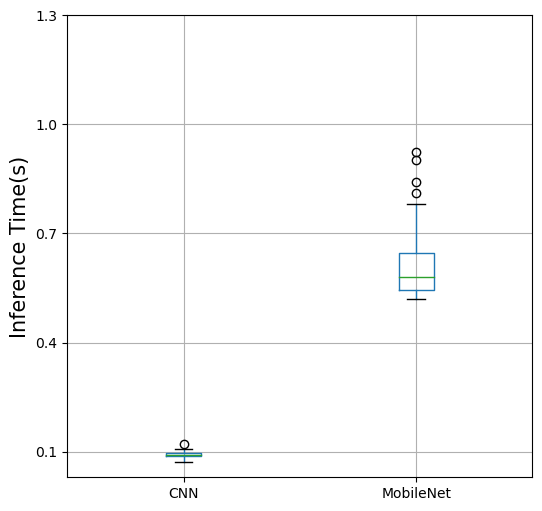

In [75]:
# 테스트 페이지에서의 추론 시간에 대한 boxplot

plt.figure(figsize=(6,6))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
inference_timetest_Test.boxplot()
plt.yticks(np.arange(0.1,1.5,0.3))
plt.ylabel('Inference Time(s)',fontsize=15)

plt.savefig('Inference Time(s)_Testpage_Test_CNN_MobileNET.png')
plt.show()

In [39]:
# 로컬 환경에서의 추론 속도 측정

inference_timetest =  pd.DataFrame({'CNN' : inferencetime_CNN,
                                    'MobileNet' : inferencetime_MobileNet})

print(inference_timetest['CNN'].mean(),inference_timetest['MobileNet'].mean())
print(inference_timetest['CNN'].std(),inference_timetest['MobileNet'].std())
print(inference_timetest['CNN'].max(),inference_timetest['MobileNet'].max())
print(inference_timetest['CNN'].min(),inference_timetest['MobileNet'].min())


inference_timetest.to_csv('inference_timetest.csv',index=False)
inference_timetest

0.0577138090133667 0.08234736442565918
0.008530573715803295 0.012877074182903861
0.09009003639221191 0.12906384468078613
0.048203229904174805 0.06610584259033203


,CNN,MobileNet
0,0.050296,0.083807
1,0.053904,0.075663
2,0.063230,0.085214
3,0.063103,0.090977
4,0.058613,0.079638
5,0.060773,0.110347
6,0.053724,0.095272
7,0.057051,0.077775
8,0.055042,0.079553
9,0.056079,0.080181


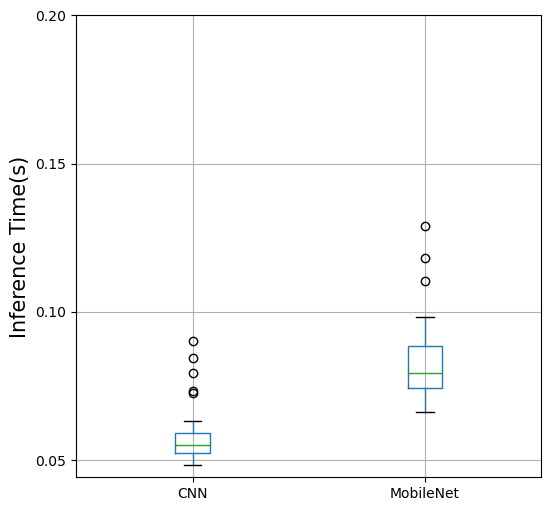

In [71]:
# 로컬에서의 추론 시간에 대한 boxplot

plt.figure(figsize=(6,6))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
inference_timetest.boxplot()
plt.yticks(np.arange(0.05,0.20,0.05))
plt.ylabel('Inference Time(s)',fontsize=15)

plt.savefig('Inference Time(s)_Local_Test_CNN_MobileNET.png')
plt.show()

#### 모바일넷과 CNN 모델 간 정확도에는 유의미한 차이가 없음 
#### 그러나, 추론 시간에서 CNN이 더 빠른 추론 속도(로컬, 테스트)를 보이며 두 모델 간 추론 속도에 유의미한 차이가 있는 것으로 파악됨 .

#### -> 이후 데이터셋에 따라 CNN을 각각 학습을 진행함